# Short literature review:

NetMHCpan-4.1 and NetMHCIIpan-4.0: improved predictions of MHC antigen presentation by concurrent motif deconvolution and integration of MS MHC eluted ligand data (2020): https://academic.oup.com/nar/article/48/W1/W449/5837056#205007562
Short paper, without any methods, but with a lot of references to other papers.

NetMHCpan-3.0; improved prediction of binding to MHC class I molecules integrating information from multiple receptor and peptide length datasets (2016): https://genomemedicine.biomedcentral.com/articles/10.1186/s13073-016-0288-x#Sec2 
A bit more detailed paper, but still not enough to reproduce the method.

Reliable prediction of T-cell epitopes using neural networks with novel sequence representations (2009): https://onlinelibrary.wiley.com/doi/10.1110/ps.0239403
Presentation of Blosum encoding which is used in all NetMHCpan papers.

CapsNet-MHC predicts peptide-MHC class I binding based on capsule neural networks (2023): https://www.nature.com/articles/s42003-023-04867-2#Sec10 
More recent paper which uses convolutions and attention blocks in the architecture. Architecture also has access to the MHC sequence which is not our case. 

DeepMHCII: a novel binding core-aware deep interaction model for accurate MHC-II peptide binding affinity prediction (2022) https://academic.oup.com/bioinformatics/article/38/Supplement_1/i220/6617501#401894415
Very similar to the previous paper, but for MHC-II. Also uses convolutions and has access to the MHC sequence.




A quick literature search revealed that the NetMHCpan method is based mainly on feed forward neural nets with a specific way to represent the amino acid sequence with Blosum encoding rather than classical one hot encoding. This encoding gives prior knowledge to the relationship between the different amino acids. As the base of the method relies on a feed forward neural net with a fixed input shape of 9 amino acids, some tricks are introduced to handle peptides of different lengths (with insertion and deletion). Then, the method does not seem to rely on the allele version but it is not clearly stated. 

The neural net in the literature is basically a feed forward neural network with a hidden layer of 56 or 66 neurons.

# Proposed method

Summary of the method:

- Processing: drop peptides with length > 14, drop peptides with amino acid X (as it is underrepresented), not keeping the allele version (for simplicity)
- Simple baseline with classical one hot encoding and embedding layer, max length set to 14 with padding if needed.
- Evaluation with AUC and F1 score
- 5 folds cross validation and ensembling

In [1]:
%load_ext autoreload
%autoreload 2

Import the data

In [2]:
import pandas as pd
import torch


folds = [pd.read_csv(f"data/fold_{i}.csv") for i in range(5)]
test = pd.read_csv("data/test.csv")

# drop rows with peptides of length > 14
for i, fold in enumerate(folds):
    mask = fold["peptide"].str.len() <= 14
    folds[i] = fold[mask]

# drop rows with peptides containing X
for i, fold in enumerate(folds):
    mask = ~fold["peptide"].str.contains("X")
    folds[i] = fold[mask]

Create dataloaders for each fold and for evaluation

In [4]:
from src.dataset import fold_dataloaders, get_test_dataloader

train_val_dataloaders = fold_dataloaders(folds, batch_size=1024, num_workers=0)

test_dataloader = get_test_dataloader(test, batch_size=1024, num_workers=0)

Train one model with one fold and evaluate it on the test set.

In [30]:
from src.training import train_loop, test_loop
from torchmetrics.classification import BinaryF1Score, BinaryAUROC
from src.models import LinearNet, ConvolutionalNet

train_dataloader, val_dataloader = train_val_dataloaders[0]
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 5

metrics = [BinaryF1Score(threshold=0.5).to(device), BinaryAUROC().to(device)]

linear_model = LinearNet(
    embedding_dimension=2, hidden_dims=[64, 128, 128, 64], output_dimension=1
)

linear_model.to(device)

loss_function = torch.nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(linear_model.parameters(), lr=0.01)

train_loss = []
test_loss = []
f1 = []
auroc = []
for epoch in range(epochs):
    train_loss.append(
        train_loop(linear_model, train_dataloader, optimizer, loss_function, device)
    )

    test_loss_value, test_metrics = test_loop(
        linear_model, test_dataloader, loss_function, metrics, device
    )
    test_loss.append(test_loss_value)
    f1.append(test_metrics[0])
    auroc.append(test_metrics[1])

100%|██████████| 924/924 [00:35<00:00, 25.80it/s]


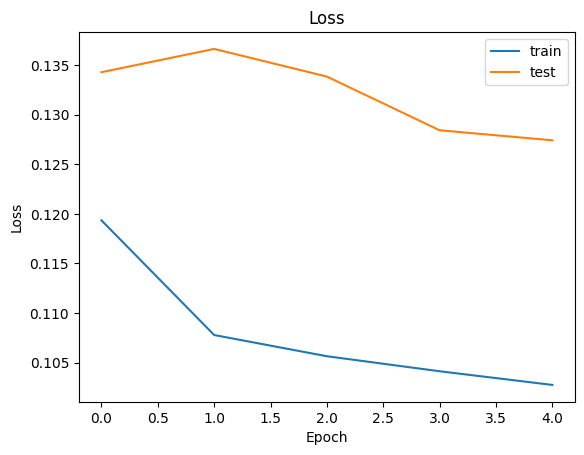

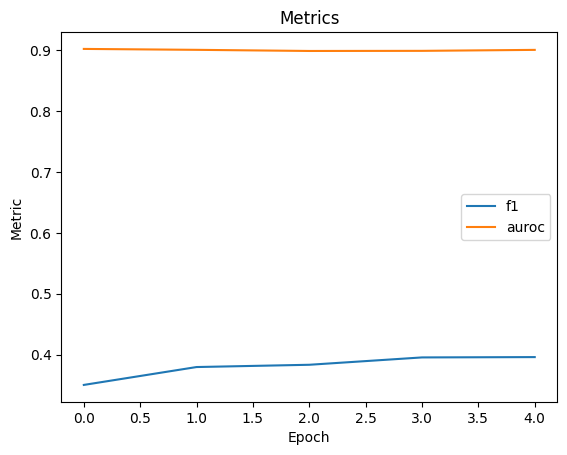

In [32]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train")
plt.plot(test_loss, label="test")
plt.legend()
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(f1, label="f1")
plt.plot(auroc, label="auroc")
plt.legend()
plt.title("Metrics")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.show()

The metrics do improve with more epochs but for simplicity we will only train for one epoch in the rest of the notebook.

Train two models (one simple feedforward and a convolutional network) per fold for one epoch and evaluate them on the test set. 

In [33]:
from src.training import train_loop, test_loop
from torchmetrics.classification import BinaryF1Score, BinaryAUROC

device = "cuda" if torch.cuda.is_available() else "cpu"

metrics = [BinaryF1Score(threshold=0.5).to(device), BinaryAUROC().to(device)]
loss_function = torch.nn.BCEWithLogitsLoss().to(device)


linear_fold_models = [
    LinearNet(embedding_dimension=2, hidden_dims=[32, 64], output_dimension=1)
    for _ in range(5)
]
linear_test_f1 = []
linear_test_auc = []

conv_fold_models = [
    ConvolutionalNet(embedding_dimension=2, filters=[32, 64], output_dimension=1)
    for _ in range(5)
]

conv_test_f1 = []
conv_test_auc = []

for i, model in enumerate(linear_fold_models):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    train_loop(model, train_val_dataloaders[i][0], optimizer, loss_function, device)
    _, test_metrics = test_loop(model, test_dataloader, loss_function, metrics, device)

    linear_test_f1.append(test_metrics[0])
    linear_test_auc.append(test_metrics[1])


for i, model in enumerate(conv_fold_models):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    train_loop(model, train_val_dataloaders[i][0], optimizer, loss_function, device)
    _, test_metrics = test_loop(model, test_dataloader, loss_function, metrics, device)

    conv_test_f1.append(test_metrics[0])
    conv_test_auc.append(test_metrics[1])

100%|██████████| 924/924 [00:37<00:00, 24.91it/s]


Save the models

In [34]:
import os

os.makedirs("weights", exist_ok=True)

for i, model in enumerate(linear_fold_models):
    torch.save(model.state_dict(), f"weights/linear_fold_{i}.pt")

for i, model in enumerate(conv_fold_models):
    torch.save(model.state_dict(), f"weights/conv_fold_{i}.pt")

Load the models

In [ ]:
linear_fold_models = [
    LinearNet(embedding_dimension=2, hidden_dims=[32, 64], output_dimension=1)
    for _ in range(5)
]
conv_fold_models = [
    ConvolutionalNet(embedding_dimension=2, filters=[32, 64], output_dimension=1)
    for _ in range(5)
]

for i, model in enumerate(linear_fold_models):
    model.load_state_dict(torch.load(f"weights/linear_fold_{i}.pt"))

for i, model in enumerate(conv_fold_models):
    model.load_state_dict(torch.load(f"weights/conv_fold_{i}.pt"))

Combine the trained models with an ensemble. The ensemble is an average on the probabilities of the models trained on each fold. It can be interpreted as a weighted vote.

In [37]:
from src.models import MergeModels

linear_ensemble = MergeModels(linear_fold_models)
conv_ensemble = MergeModels(conv_fold_models)

linear_ensemble.to(device)
conv_ensemble.to(device)

_, linear_ensemble_metrics = test_loop(
    linear_ensemble, test_dataloader, loss_function, metrics, device
)

_, conv_ensemble_metrics = test_loop(
    conv_ensemble, test_dataloader, loss_function, metrics, device
)

100%|██████████| 924/924 [00:41<00:00, 22.38it/s]


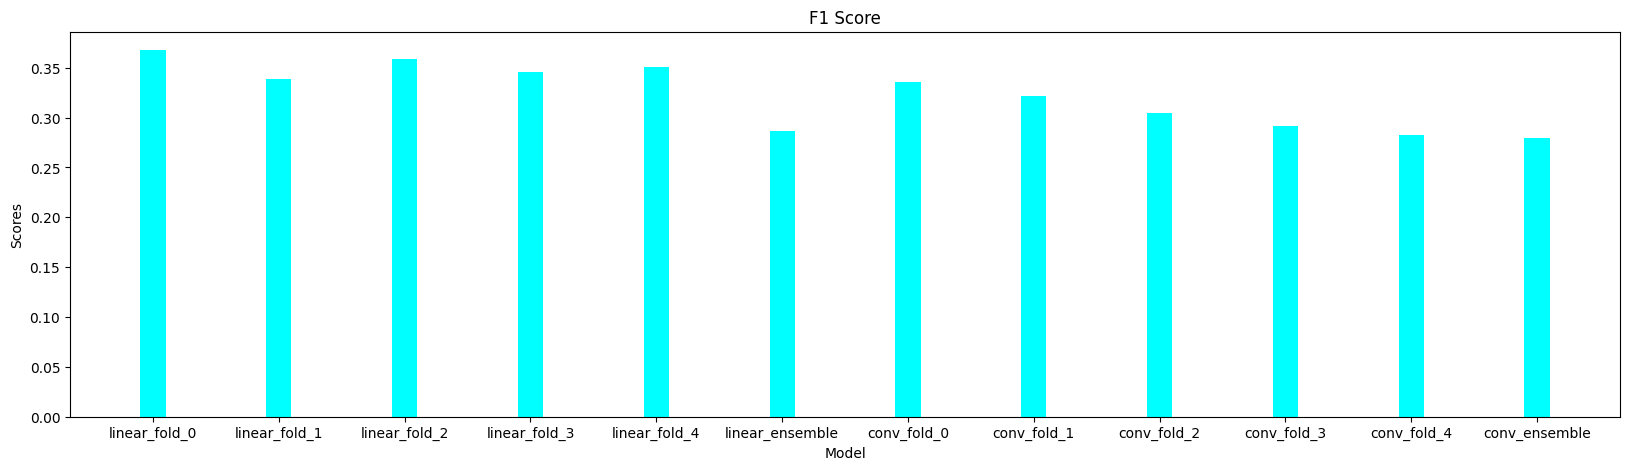

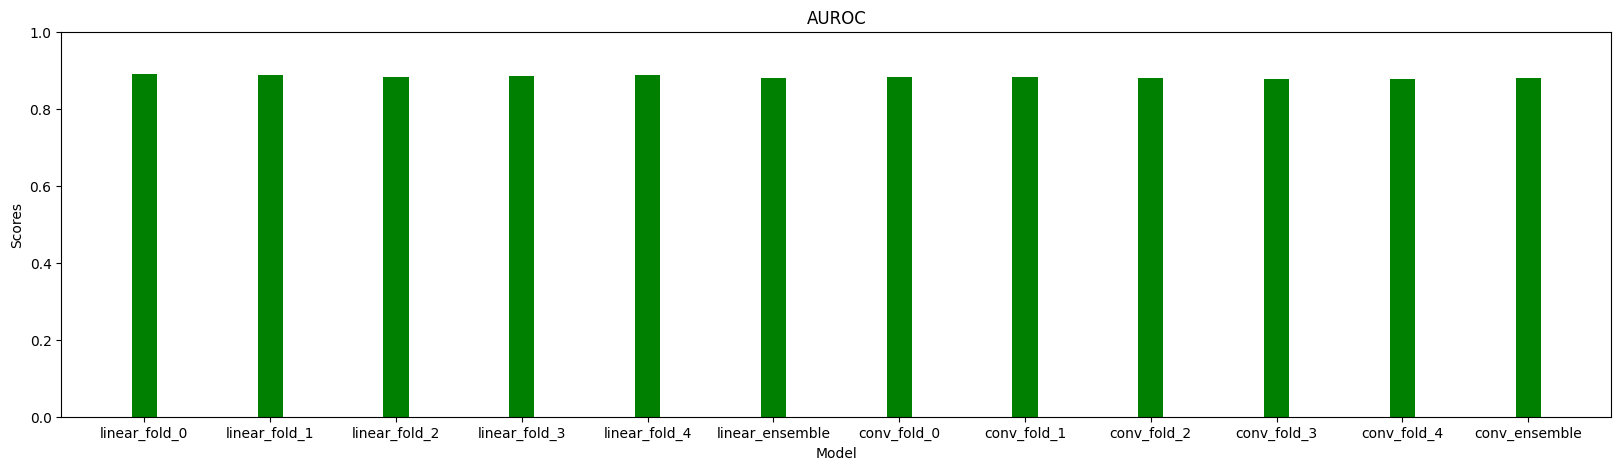

In [38]:
import matplotlib.pyplot as plt
import numpy as np

x_labels = (
    [f"linear_fold_{i}" for i in range(5)]
    + ["linear_ensemble"]
    + [f"conv_fold_{i}" for i in range(5)]
    + ["conv_ensemble"]
)

x = np.arange(len(x_labels))
test_f1 = (
    linear_test_f1
    + [linear_ensemble_metrics[0]]
    + conv_test_f1
    + [conv_ensemble_metrics[0]]
)
test_auc = (
    linear_test_auc
    + [linear_ensemble_metrics[1]]
    + conv_test_auc
    + [conv_ensemble_metrics[1]]
)

width = 0.2


plt.figure(figsize=(20, 5))
plt.bar(x, test_f1, width, color="cyan")
plt.xticks(x, x_labels)
plt.xlabel("Model")
plt.ylabel("Scores")
plt.title("F1 Score")
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(x, test_auc, width, color="green")
plt.xticks(x, x_labels)
plt.xlabel("Model")
plt.ylabel("Scores")
plt.ylim([0, 1])
plt.title("AUROC")
plt.show()

Something suprising is that the ensemble does not improve the metrics and even decreases them. This might be because of common biases in the models which might be amplified by the ensemble. Indeed, the models are trained on unbalanced data and the ensemble might be biased towards the majority class as nothing is done to counter this effect.

The linear models have slightly better metrics than the convolutional ones. This might be because the convolutional models have much less parameters and are not deep enough to separate the data. The comparison would be much more interesting with a deeper convolutional model. After all, the convolutional models are linear models with shared weights.

In [40]:
argsort = np.argsort(test_auc)[::-1]

for i in range(5):
    print(x_labels[argsort[i]], test_auc[argsort[i]])

linear_fold_0 0.8898307
linear_fold_1 0.88714576
linear_fold_4 0.88612413
linear_fold_3 0.8847561
conv_fold_0 0.8832276


The results we get are pretty close to the ones of NetMHCpan-3.0 which has AUC slightly below 0.9. The results are not directly comparable because the dataset is probably different. Note that, my first model with more parameters and trained for 5 epochs gets an AUC over 0.9. Otherwise, the major differences in the methods I employed is in the representation: I used classical one hot encoding and embedding layer while NetMHCpan uses Blosum encoding. I also trained with longer sequences (up to 14 amino acids) while NetMHCpan only uses 9 amino acids and uses deletion and insertions methods. The results are not comparable to NetMHCpan-3.0 which uses a different metric.

# Potential improvements

- Fine-tuning, longer training, bigger models, more powerful architectures (RNN, residual blocks, attention blocks, ...)
- Use Blosum encoding, use deletion and insertion methods as in previous papers
- Give the allele version to the model as input or even the MHC sequence
- Use regularization methods: dropout, weight decay, label smoothing, ...
- Counter the unbalanced data: oversampling, undersampling, class weights, ...